<h2 align = "center">Mod 5: Softmax</h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import latte
import latte.nn as nn
import latte.optim as optim
import latte.functional as F
import latte.utils.data as data

import lattevision as lv
import lattevision.datasets as dsets
import lattevision.transforms as T


In [2]:
mnist_root = '../data/mnist'
mnist_transform = T.Compose([T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])

mnist_train = dsets.MNIST(mnist_root, train=True, transform=mnist_transform)
mnist_test = dsets.MNIST(mnist_root, train=False, transform=mnist_transform)

val_len = len(mnist_train) // 10
train_len = len(mnist_train) - val_len
mnist_train, mnist_val = data.random_split(mnist_train, [train_len, val_len])

train_batch_size = 128
test_batch_size = 512

train_loader = data.DataLoader(mnist_train, batch_size=train_batch_size, shuffle=True)
val_loader = data.DataLoader(mnist_val, batch_size=train_batch_size, shuffle=False)
test_loader = data.DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False)


In [3]:
class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


model_mse = Model()
model_sm = Model()
criterion_mse = nn.MSELoss()
criterion_sm = nn.CrossEntropyLoss()
optimizer_mse = optim.SGD(model_mse.parameters(), lr=1e-3, momentum=0)
optimizer_sm = optim.SGD(model_sm.parameters(), lr=1e-3, momentum=0)


In [4]:
max_epochs = 15

train_losses_mse = []
train_losses_sm = []
train_accuracies_mse = []
train_accuracies_sm = []

val_losses_mse = []
val_losses_sm = []
val_accuracies_mse = []
val_accuracies_sm = []

for epoch in range(max_epochs):
    # Training
    epoch_loss_mse = 0
    epoch_loss_sm = 0
    epoch_accuracy_mse = 0
    epoch_accuracy_sm = 0
    epoch_batchs = 0

    for ii, (data, target) in enumerate(train_loader):
        batch_size = data.shape[0]
        if batch_size != train_batch_size:
            continue
        epoch_batchs += 1

        data = latte.Tensor(data.reshape(batch_size, -1))
        # MSELoss target shape: (batch_size, 10) with one-hot encoding
        # CrossEntropyLoss target shape: (batch_size, ) with labels
        target_mse = np.zeros((batch_size, 10))
        target_mse[np.arange(batch_size), target] = 1
        target_mse = latte.Tensor(target_mse)
        target_sm = latte.Tensor(target)

        # Forward pass
        optimizer_mse.zero_grad()
        optimizer_sm.zero_grad()
        output_mse = model_mse(data)
        output_sm = model_sm(data)

        # Compute loss
        loss_mse = criterion_mse(output_mse, target_mse)
        epoch_loss_mse += loss_mse.data
        loss_sm = criterion_sm(output_sm, target_sm)
        epoch_loss_sm += loss_sm.data

        # Backward pass
        loss_mse.backward()
        optimizer_mse.step()
        loss_sm.backward()
        optimizer_sm.step()

        # Compute accuracy
        accuracy_mse = (output_mse.data.argmax(axis=1) == target).mean()
        epoch_accuracy_mse += accuracy_mse
        accuracy_sm = (output_sm.data.argmax(axis=1) == target).mean()
        epoch_accuracy_sm += accuracy_sm

    # Logging
    train_losses_mse.append(np.round(epoch_loss_mse / epoch_batchs, 4))
    train_losses_sm.append(np.round(epoch_loss_sm / epoch_batchs, 4))
    train_accuracies_mse.append(np.round(epoch_accuracy_mse / epoch_batchs, 4))
    train_accuracies_sm.append(np.round(epoch_accuracy_sm / epoch_batchs, 4))

    # Validation
    epoch_loss_mse = 0
    epoch_loss_sm = 0
    epoch_accuracy_mse = 0
    epoch_accuracy_sm = 0
    epoch_batchs = 0
    
    for data, target in val_loader:
        batch_size = data.shape[0]
        if batch_size != train_batch_size:
            continue
        epoch_batchs += 1

        data = latte.Tensor(data.reshape(batch_size, -1))
        target_mse = np.zeros((batch_size, 10))
        target_mse[np.arange(batch_size), target] = 1
        target_mse = latte.Tensor(target_mse)
        target_sm = latte.Tensor(target)

        output_mse = model_mse(data)
        output_sm = model_sm(data)

        # Compute loss
        loss_mse = criterion_mse(output_mse, target_mse)
        epoch_loss_mse += loss_mse.data
        loss_sm = criterion_sm(output_sm, target_sm)
        epoch_loss_sm += loss_sm.data

        # Compute accuracy
        accuracy_mse = (output_mse.data.argmax(axis=1) == target).mean()
        epoch_accuracy_mse += accuracy_mse
        accuracy_sm = (output_sm.data.argmax(axis=1) == target).mean()
        epoch_accuracy_sm += accuracy_sm

    # Logging
    val_losses_mse.append(np.round(epoch_loss_mse / epoch_batchs, 4))
    val_losses_sm.append(np.round(epoch_loss_sm / epoch_batchs, 4))
    val_accuracies_mse.append(np.round(epoch_accuracy_mse / epoch_batchs, 4))
    val_accuracies_sm.append(np.round(epoch_accuracy_sm / epoch_batchs, 4))

print('MSE:')
print('Training')
print(f'\tLoss: {train_losses_mse}')
print(f'\tAccuracy: {train_accuracies_mse}')
print('Validation')
print(f'\tLoss: {val_losses_mse}')
print(f'\tAccuracy: {val_accuracies_mse}')
print('Softmax:')
print('Training')
print(f'\tLoss: {train_losses_sm}')
print(f'\tAccuracy: {train_accuracies_sm}')
print('Validation')
print(f'\tLoss: {val_losses_sm}')
print(f'\tAccuracy: {val_accuracies_sm}')


MSE:
Training
	Loss: [0.0429, 0.035, 0.0296, 0.0262, 0.0241, 0.0225, 0.0213, 0.0202, 0.0193, 0.0186, 0.0178, 0.0172, 0.0166, 0.0161, 0.0156]
	Accuracy: [0.4223, 0.7033, 0.7504, 0.7777, 0.7991, 0.816, 0.8275, 0.8381, 0.8474, 0.8544, 0.8605, 0.8662, 0.871, 0.8751, 0.8784]
Validation
	Loss: [0.0383, 0.0319, 0.0277, 0.0251, 0.0233, 0.022, 0.0209, 0.02, 0.0191, 0.0184, 0.0177, 0.0171, 0.0166, 0.016, 0.0156]
	Accuracy: [0.6542, 0.7335, 0.7611, 0.7825, 0.7997, 0.8151, 0.8248, 0.838, 0.8453, 0.8524, 0.8575, 0.8615, 0.8667, 0.8726, 0.8774]
Softmax:
Training
	Loss: [2.26, 2.1155, 1.8332, 1.4595, 1.14, 0.9242, 0.7837, 0.6884, 0.6205, 0.5703, 0.5319, 0.5012, 0.4764, 0.4556, 0.4386]
	Accuracy: [0.3723, 0.6054, 0.6669, 0.7209, 0.7694, 0.8054, 0.8256, 0.8398, 0.852, 0.8593, 0.8665, 0.8717, 0.876, 0.8799, 0.8831]
Validation
	Loss: [2.2061, 2.0008, 1.65, 1.2844, 1.0209, 0.8509, 0.7389, 0.6615, 0.6055, 0.5634, 0.5305, 0.5043, 0.4831, 0.4654, 0.4506]
	Accuracy: [0.5455, 0.6465, 0.6969, 0.7502, 0.7951, 0.

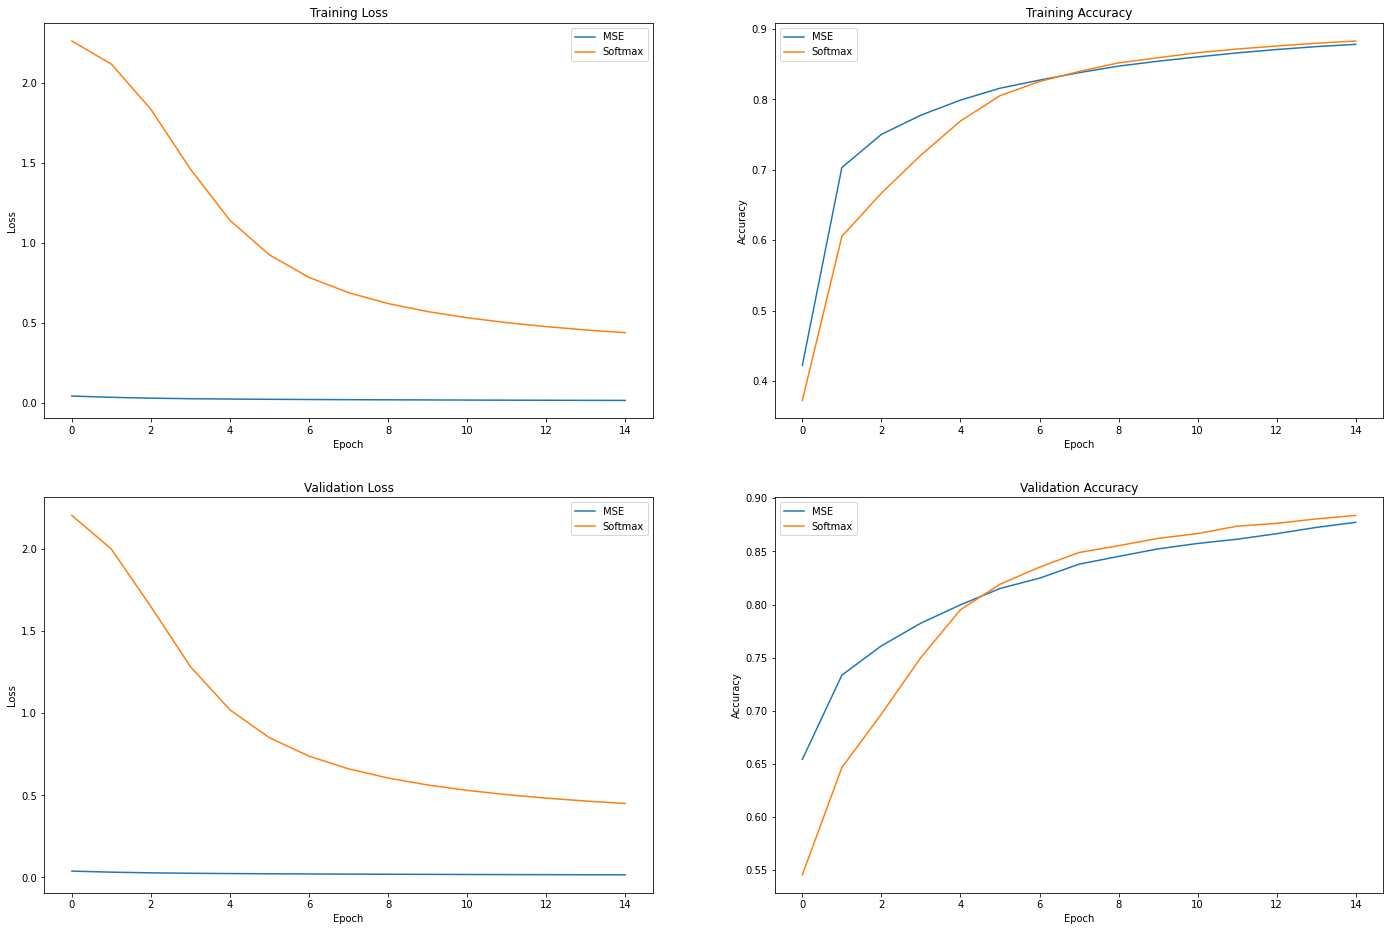

In [5]:
# Plot
plt.figure(figsize=(24, 16))

plt.subplot(2, 2, 1)
plt.plot(train_losses_mse, label='MSE')
plt.plot(train_losses_sm, label='Softmax')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_accuracies_mse, label='MSE')
plt.plot(train_accuracies_sm, label='Softmax')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(val_losses_mse, label='MSE')
plt.plot(val_losses_sm, label='Softmax')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(val_accuracies_mse, label='MSE')
plt.plot(val_accuracies_sm, label='Softmax')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [6]:
# Test
correct_mse = 0
correct_sm = 0
total = 0
for data, target in test_loader:
    batch_size = data.shape[0]
    if batch_size != test_batch_size:
        continue

    data = latte.Tensor(data.reshape(batch_size, -1))
    target = latte.Tensor(target)

    output_mse = model_mse(data)
    output_sm = model_sm(data)
    correct_mse += (output_mse.data.argmax(axis=1) == target.data).sum()
    correct_sm += (output_sm.data.argmax(axis=1) == target.data).sum()
    total += target.shape[0]

print(f'Accuracy')
print(f'\tMSE: {(correct_mse / total): .4f}')
print(f'\tSoftmax: {(correct_sm / total): .4f}')


Accuracy
	MSE:  0.8925
	Softmax:  0.8923
